# 1.  Data import

In [82]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

In [10]:
df_train = pd.read_csv("Dane.csv") # chinese 195 patients
df_test = pd.read_csv("Dane_test.csv") # chinese 79 patients
df_test2 = pd.read_csv("Dane_test2.csv") # dutch 198 patients
df_test3 = pd.read_csv("Dane_test3.csv") # american 1038 patients

# Removing unnecessary colums
df_train = df_train[["outcome", "c_protein", "c_protein_change", "lactate", "lactate_change", "lymphocyte", "lymphocyte_change"]]
df_test = df_test[["outcome", "c_protein", "c_protein_change", "lactate", "lactate_change", "lymphocyte", "lymphocyte_change"]]
df_test2 = df_test2[["outcome", "c_protein", "c_protein_change", "lactate", "lactate_change", "lymphocyte", "lymphocyte_change"]]
df_test3 = df_test3[["outcome", "c_protein", "c_protein_change", "lactate", "lactate_change", "lymphocyte", "lymphocyte_change"]]

# Create new dataset which contains all previous datasets
frames = [df_train, df_test, df_test2, df_test3]
df_whole = pd.concat(frames)
#df_whole.to_csv("Dane_merged.csv", index = False)

#### Testing function

In [77]:
# Function for model score print
def model_metrics(Y, Y_pred):
    
    Metrics = []
    Metrics.append(accuracy_score(Y, Y_pred))
    Metrics.append(recall_score(Y, Y_pred))
    Metrics.append(precision_score(Y, Y_pred))
    Metrics.append(f1_score(Y, Y_pred))
    
    print("Confusion Matrix:")
    print(confusion_matrix(Y, Y_pred))
    print("###################")
    print("Accuracy: ", Metrics[0])
    print("Recall: ", Metrics[1])
    print("Precision: ", Metrics[2])
    print("F1: ", Metrics[3])
    
    return Metrics

In [13]:
# Function for rendering dataframe as table
def render_mpl_table(data, col_width=3.0, row_height=0.825, font_size=18,
                     header_color='#2c7fb8', row_colors=['#f9f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

# 2. Logistic Regression

#### Data preparation


In [89]:
df_test = df_whole.sample(math.floor(len(df_whole) / 5))
df_train = df_whole.drop(df_test.index)

Y_train = df_train.outcome
X_train = df_train.drop("outcome", 1)

Y_test = df_test.outcome
X_test = df_test.drop("outcome", 1)

scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Model Fitting

In [90]:
pipe = Pipeline([('classifier' , LogisticRegression())])

# Create param grid.

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.linspace(-2, 2, 100),
    'classifier__solver' : ['liblinear', 'lbfgs']}]

# Create grid search object

clf_log = model_selection.GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=False,
                                       n_jobs=-1, scoring="f1")

# Fit on data

best_clf_log = clf_log.fit(X_train_scaled, Y_train)

In [91]:
best_clf_log.best_estimator_

Pipeline(steps=[('classifier',
                 LogisticRegression(C=0.7474747474747478, penalty='l1',
                                    solver='liblinear'))])

#### Model testing

In [92]:
log_preds = best_clf_log.predict(X_test_scaled)

log_score_merged = model_metrics(Y_test, log_preds)

Confusion Matrix:
[[178  13]
 [ 34  63]]
###################
Accuracy:  0.8368055555555556
Recall:  0.6494845360824743
Precision:  0.8289473684210527
F1:  0.7283236994219654


#### Checking coefficents

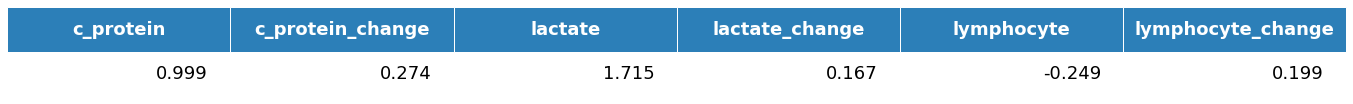

In [93]:
from pandas.plotting import table
import six

coefficents_log =  pd.DataFrame( np.around(best_clf_log.best_estimator_[0].coef_, 3))
coefficents_log.columns = ["c_protein", "c_protein_change", "lactate", 
                           "lactate_change", "lymphocyte", "lymphocyte_change"]

log_score_table = render_mpl_table(coefficents_log, header_columns=0, col_width=4.0)
plt.savefig("log_score_merged.png")
plt.show()

# 3. Algorithm from article

#### Implementation

In [94]:
def tree(sample):
    if sample.lactate < 365:
        if sample.c_protein < 41.2:
            return 0
        else:
            if sample.lymphocyte > 14.7:
                return 0
            else:
                return 1
    else:
        return 1

#### Model Fitting

In [95]:
tree_preds = []
for i in range(len(X_test)):
    tree_preds.append(tree(X_test.iloc[i]))

#### Model Testing

In [96]:
tree_score_merged = model_metrics(Y_test, tree_preds)

Confusion Matrix:
[[93 98]
 [ 7 90]]
###################
Accuracy:  0.6354166666666666
Recall:  0.9278350515463918
Precision:  0.4787234042553192
F1:  0.6315789473684211


# 4. Tabnet 

#### Data preparation

In [97]:
df_train_v = df_train.sample(math.floor(len(df_train) / 10)) # Validation set will be 1/10 of training set
df_train_t = df_train.drop(df_train_v.index)

Y_train_t = df_train_t.outcome
X_train_t = df_train_t.drop("outcome", 1)

Y_train_v = df_train_v.outcome
X_train_v = df_train_v.drop("outcome", 1)

scaler = preprocessing.StandardScaler().fit(X_train_t)

X_train_t = scaler.transform(X_train_t)
X_train_v = scaler.transform(X_train_v)

#### Model Fitting

In [98]:
from pytorch_tabnet.tab_model import TabNetClassifier

clf_tab = TabNetClassifier(seed = 123)
clf_tab.fit(X_train_t, Y_train_t, eval_set = [(X_train_v, Y_train_v)])
tab_preds = clf_tab.predict(X_test_scaled)

Device used : cpu
epoch 0  | loss: 1.20342 | val_0_auc: 0.80199 |  0:00:00s
epoch 1  | loss: 0.78045 | val_0_auc: 0.80647 |  0:00:00s
epoch 2  | loss: 0.57931 | val_0_auc: 0.82438 |  0:00:00s
epoch 3  | loss: 0.51427 | val_0_auc: 0.83781 |  0:00:00s
epoch 4  | loss: 0.51514 | val_0_auc: 0.8408  |  0:00:00s
epoch 5  | loss: 0.51903 | val_0_auc: 0.84328 |  0:00:00s
epoch 6  | loss: 0.48146 | val_0_auc: 0.84328 |  0:00:00s
epoch 7  | loss: 0.47751 | val_0_auc: 0.84577 |  0:00:00s
epoch 8  | loss: 0.46892 | val_0_auc: 0.84677 |  0:00:00s
epoch 9  | loss: 0.4646  | val_0_auc: 0.85174 |  0:00:00s
epoch 10 | loss: 0.45823 | val_0_auc: 0.85522 |  0:00:00s
epoch 11 | loss: 0.44251 | val_0_auc: 0.85423 |  0:00:00s
epoch 12 | loss: 0.43275 | val_0_auc: 0.86169 |  0:00:00s
epoch 13 | loss: 0.44163 | val_0_auc: 0.8607  |  0:00:00s
epoch 14 | loss: 0.43116 | val_0_auc: 0.86517 |  0:00:00s
epoch 15 | loss: 0.43273 | val_0_auc: 0.87114 |  0:00:00s
epoch 16 | loss: 0.42034 | val_0_auc: 0.87463 |  0:00:

#### Model Testing

In [99]:
tab_score_merged = model_metrics(Y_test, tab_preds)

Confusion Matrix:
[[179  12]
 [ 30  67]]
###################
Accuracy:  0.8541666666666666
Recall:  0.6907216494845361
Precision:  0.8481012658227848
F1:  0.7613636363636364


#### Global Explainability

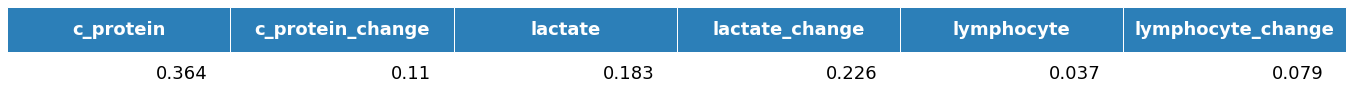

In [100]:
coefficents_tab = pd.DataFrame(np.around(clf_tab.feature_importances_, 3)).transpose()
coefficents_tab.columns = ["c_protein", "c_protein_change", "lactate", 
                           "lactate_change", "lymphocyte", "lymphocyte_change"]

log_score_table = render_mpl_table(coefficents_tab, header_columns=0, col_width=4.0)
plt.savefig("tab_score_merged.png")
plt.show()

#### Local Explainability

In [101]:
explain_matrix, masks = clf_tab.explain(X_test_scaled)

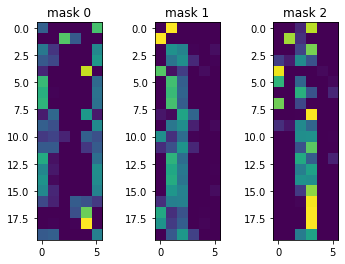

In [102]:
fig, ax = plt.subplots(1,3)
for i in range(3):
    ax[i].imshow(masks[i][:20])
    ax[i].set_title(f"mask {i}")
plt.savefig("tab_masks_merged.png")

# 5. SVM

#### Model Fitting

In [103]:
from sklearn import svm

# Create param grid.

param_grid = {'C': np.linspace(0.1, 2, 20), 'gamma': np.linspace(0.01, 1, 25),'kernel': ['rbf', 'poly', 'sigmoid']}

# Create grid search object

clf_svm = model_selection.GridSearchCV(svm.SVC(), param_grid = param_grid, cv = 5, verbose=False,
                                       n_jobs=-1, scoring="f1")

best_clf_svm = clf_svm.fit(X_train_scaled, Y_train)

In [64]:
clf_svm.best_estimator_

SVC(C=1.2, gamma=0.051250000000000004, kernel='sigmoid')

In [104]:
svm_preds = clf_svm.predict(X_test_scaled)

#### Model Testing

In [105]:
svm_score_merged = model_metrics(Y_test, svm_preds)

Confusion Matrix:
[[168  23]
 [ 27  70]]
###################
Accuracy:  0.8263888888888888
Recall:  0.7216494845360825
Precision:  0.7526881720430108
F1:  0.736842105263158


# 6. Visualization

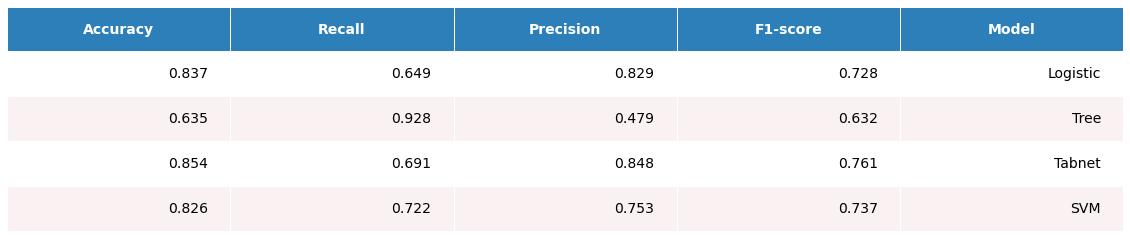

In [107]:
merged_results = pd.DataFrame([np.around(log_score_merged, 3), np.around(tree_score_merged, 3),
                                np.around(tab_score_merged, 3), np.around(svm_score_merged, 3)], columns= ["Accuracy", "Recall", "Precision", "F1-score"])
merged_results["Model"] = ["Logistic", "Tree", "Tabnet", "SVM"]

merged_results_plot = render_mpl_table(merged_results, header_columns=0, col_width=4.0, font_size= 14)
plt.savefig("merged_results.png")
plt.show()

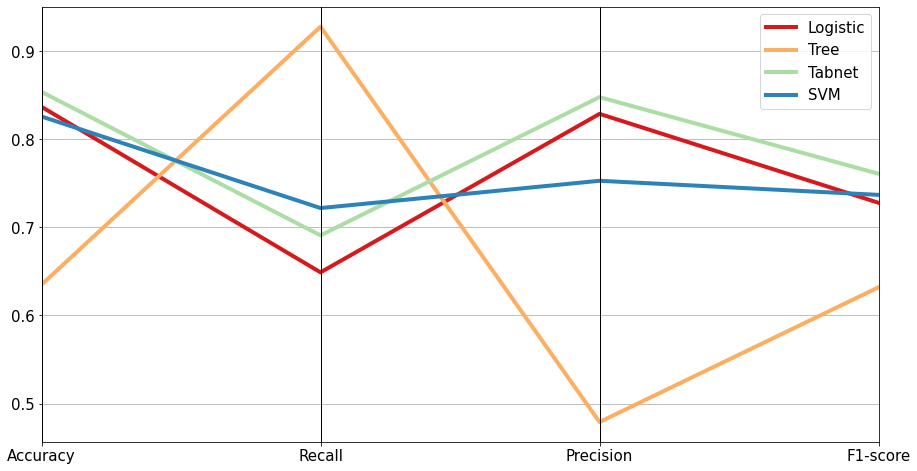

In [108]:
fig, ax = plt.subplots(figsize = (15, 8))
ax = pd.plotting.parallel_coordinates(merged_results, 'Model', color=('#d7191c', '#fdae61', '#abdda4','#2b83ba'), linewidth = 4)
plt.legend(fontsize = 15)
ax.tick_params(axis = "both", which = "major", labelsize = 15)
plt.savefig("merged_parallel.png")
plt.show()